# Gathering data

In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *
from pathlib import Path

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', 'fa628bcbbf504c87bf6525ab584a1d48')

In [4]:
results = search_images_bing(key, 'winner dog')
ims = results.attrgot('content_url')
len(ims)

150

In [5]:
dog_types = 'Winner','Chihuahua','Basset Hound'
path = Path('dogs')

In [6]:
if not path.exists():
    path.mkdir()
    for o in dog_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} dog')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [7]:
fns = get_image_files(path)
fns

(#415) [Path('dogs/Winner/641d7abe-6155-4778-a8ad-2d0a59843965.jpg'),Path('dogs/Winner/6e1d2886-43ec-4fef-84b8-ff394b208edb.jpg'),Path('dogs/Winner/2a7c9da1-8ed5-4919-a75e-842031332391.jpg'),Path('dogs/Winner/ba40b3ea-60ec-48db-a400-945e5c6c8eaf.jpg'),Path('dogs/Winner/2fcf5bb6-1e93-4fba-82be-2e5cefebfbf6.jpg'),Path('dogs/Winner/accf691d-5d06-44d6-bb68-af07c3e712cb.jpg'),Path('dogs/Winner/2ef7c70f-aa98-4f3e-a5a4-ef11c2b83b12.jpg'),Path('dogs/Winner/7fc7b0cf-94d1-4bdc-8003-d05791b2ee7c.jpg'),Path('dogs/Winner/ee9b0a82-8e52-4e4b-a46b-7ff59b402533.png'),Path('dogs/Winner/db665732-182c-4c6c-b7cd-e69d07e49f61.jpg')...]

# Clean data

In [8]:
failed = verify_images(fns)
failed

(#9) [Path('dogs/Winner/b5c398b0-ea3a-4c7e-8dcf-fb287028e9ab.jpg'),Path('dogs/Winner/4696e20a-09a5-4f3c-8d68-de118ffa3558.jpg'),Path('dogs/Winner/35f66bd3-70f3-4f00-a755-101ccd76174c.jpg'),Path('dogs/Winner/96169512-1015-4b83-96fb-548d91001661.jpg'),Path('dogs/Winner/9bfe50ac-78e1-4f51-a89f-064e49e6f877.jpg'),Path('dogs/Basset Hound/0bcdc13e-fdf7-4bcd-a1d9-af640786e910.jpg'),Path('dogs/Basset Hound/3e712d5c-f5c5-4897-bcec-3428bc338532.jpg'),Path('dogs/Basset Hound/c4644f24-ffbe-44dd-bb2a-cac78ba6fd86.jpg'),Path('dogs/Basset Hound/06665f97-59ac-449b-af1a-215d27e07722.jpg')]

In [9]:
failed.map(Path.unlink);

# Dataloader

In [10]:
dogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=1),
    get_y=parent_label,
    item_tfms=Resize(128))

In [11]:
dls = dogs.dataloaders(path)

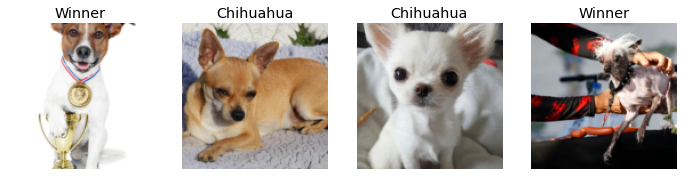

In [12]:
dls.valid.show_batch(max_n=4, nrows=1)

By default `Resize` *crops* the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. Alternatively, you can ask fastai to pad the images with zeros (black), or squish/stretch them:

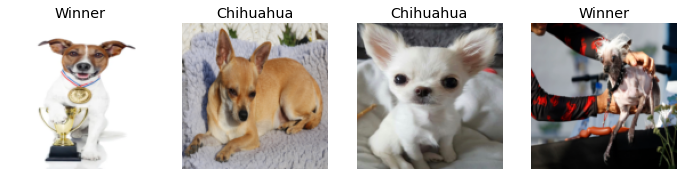

In [13]:
dogs = dogs.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = dogs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

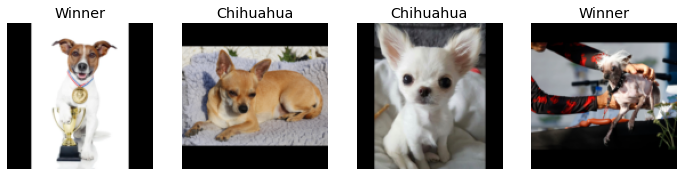

In [14]:
dogs = dogs.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = dogs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

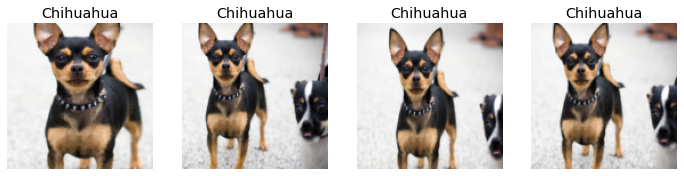

In [15]:
dogs = dogs.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [16]:
dogs = dogs.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:


NotImplementedError: The operator 'aten::_linalg_solve_ex.result' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [17]:
dogs = dogs.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = dogs.dataloaders(path)

Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:


NotImplementedError: The operator 'aten::_linalg_solve_ex.result' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

# Training Your Model, and Using It to Clean Your Data

In [18]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/Users/minjae/opt/anaconda3/lib/python3.9/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


epoch,train_loss,valid_loss,error_rate,time
0,1.617959,0.578986,0.185185,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.733285,0.361317,0.123457,00:11
1,0.562039,0.261385,0.086420,00:09
2,0.443345,0.216267,0.074074,00:09
3,0.359685,0.225977,0.074074,00:09


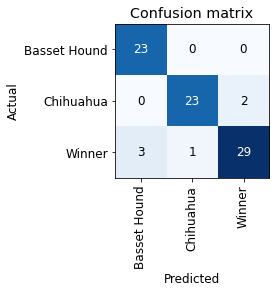

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

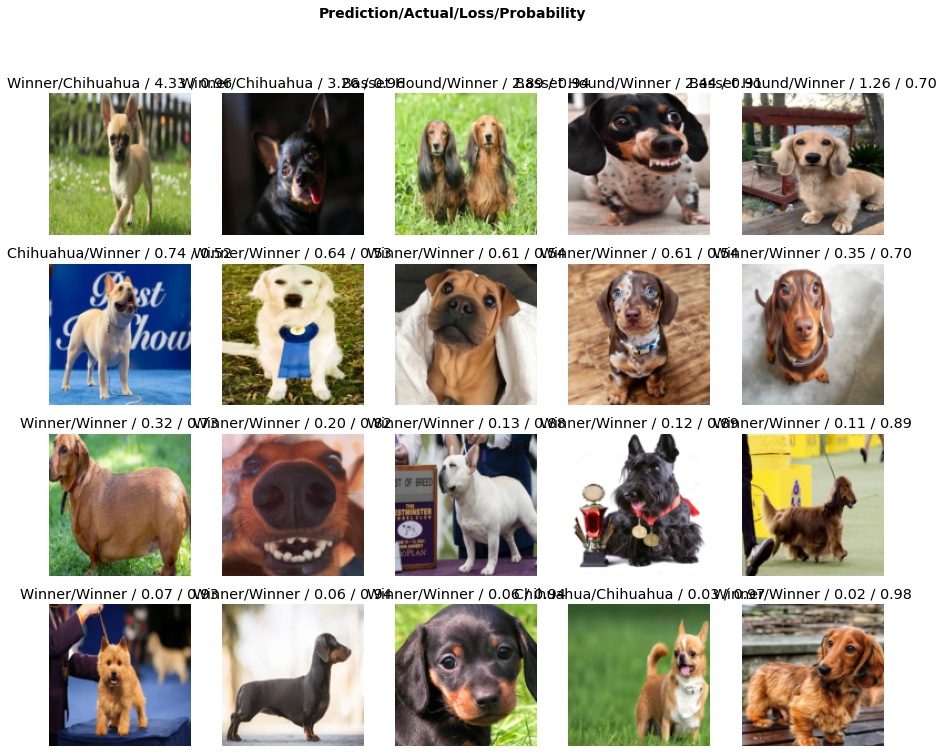

In [20]:
interp.plot_top_losses(20, nrows=4)

In [21]:
cleaner = ImageClassifierCleaner(learn, max_n=150)
cleaner

In [22]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

# Save model

In [23]:
learn.export('dog.pkl')

In [24]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('dog.pkl')]

In [25]:
learn = load_learner('dog.pkl')